<a href="https://colab.research.google.com/github/anildoferreira/projetos-pln/blob/main/weekly-studies/semana-07-classificacao-svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semana 7: Desafio - Classificação de SPAM com SVM

**Objetivo:** Construir um pipeline completo de Processamento de Linguagem Natural para classificar mensagens de SMS como SPAM ou HAM (não-spam).

Este notebook irá realizar as seguintes etapas:
1.  **Carregamento dos Dados:** Baixar e carregar o dataset "SMS Spam Collection".
2.  **Pré-processamento:** Limpar e preparar o texto das mensagens.
3.  **Vetorização:** Converter o texto limpo em vetores numéricos.
4.  **Treinamento e Solução do Desafio:** Treinar um classificador **Support Vector Machine (SVM)** e visualizar sua performance com uma matriz de confusão gráfica.

In [1]:
import requests
import zipfile
import io
import pandas as pd
import re
import nltk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

print("--- Etapa 1: Baixando e Carregando os Dados ---")

# URL do dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'

# Baixar e extrair o arquivo
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

# Carregar para o DataFrame do Pandas
df = pd.read_table('/content/SMSSpamCollection', header=None, names=['rotulo', 'mensagem'])

print("Dataset carregado com sucesso!")
df.head()

--- Etapa 1: Baixando e Carregando os Dados ---
Dataset carregado com sucesso!


,rotulo,mensagem
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Etapa 2: Pré-processamento e Limpeza do Texto

Nesta etapa, vamos "limpar" as mensagens de texto para que o modelo possa focar nas palavras mais importantes. Realizaremos as seguintes transformações:
- Converter tudo para letras minúsculas.
- Substituir URLs, e-mails, números, etc., por tags genéricas.
- Remover pontuação.
- Remover *stopwords* (palavras comuns como "a", "o", "de", "para").
- Aplicar *stemming* para reduzir as palavras à sua raiz (ex: "correndo" -> "corr").

In [5]:
print("\n--- Etapa 2: Realizando o Pré-processamento do Texto ---")

# Baixando pacotes do NLTK (necessário na primeira execução)
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
# Baixando o recurso punkt_tab
nltk.download('punkt_tab', quiet=True)

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

# Criando uma nova coluna para o texto processado
df['mensagem_proc'] = df['mensagem'].copy()

# Aplica as transformações
df['mensagem_proc'] = df['mensagem_proc'].str.lower()
df['mensagem_proc'] = df['mensagem_proc'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$', 'emailaddress', regex=True)
df['mensagem_proc'] = df['mensagem_proc'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$', 'webaddress', regex=True)
df['mensagem_proc'] = df['mensagem_proc'].str.replace(r'£|\$', 'moneysymb', regex=True)
df['mensagem_proc'] = df['mensagem_proc'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$', 'phonenumbr', regex=True)
df['mensagem_proc'] = df['mensagem_proc'].str.replace(r'\d+(\.\d+)?', 'numbr', regex=True)
df['mensagem_proc'] = df['mensagem_proc'].str.replace(r'[^\w\d\s]', ' ', regex=True)
df['mensagem_proc'] = df['mensagem_proc'].str.replace(r'\s+', ' ', regex=True)
df['mensagem_proc'] = df['mensagem_proc'].str.replace(r'^\s+|\s+?$', '', regex=True)

# Função para remover stopwords e aplicar stemming
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
def preprocess_text(text):
    tokens = word_tokenize(text)
    filtered_tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return " ".join(filtered_tokens)

df['mensagem_proc'] = df['mensagem_proc'].apply(preprocess_text)

print("Pré-processamento concluído.")
print("\nExemplo de mensagem original vs. processada:")
print("Original:", df['mensagem'][2])
print("Processada:", df['mensagem_proc'][2])


--- Etapa 2: Realizando o Pré-processamento do Texto ---
Pré-processamento concluído.

Exemplo de mensagem original vs. processada:
Original: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
Processada: free entri numbr wkli comp win fa cup final tkt numbrst may numbr text fa numbr receiv entri question std txt rate c appli numbrovernumbr


## Etapa 3: Vetorização e Divisão dos Dados

O modelo de machine learning não entende palavras, apenas números. Portanto, precisamos converter nossas mensagens de texto em vetores numéricos. Usaremos a técnica **Bag of Words**.

Depois, dividiremos nosso dataset em dois conjuntos:
- **Conjunto de Treinamento (75%):** Usado para ensinar o modelo.
- **Conjunto de Teste (25%):** Usado para avaliar a performance do modelo em dados que ele nunca viu.

In [6]:
print("\n--- Etapa 3: Vetorizando e Dividindo os Dados ---")

# Vetorização (Bag of Words), pegando as 1500 palavras mais frequentes
vectorizer = CountVectorizer(max_features=1500)
X = vectorizer.fit_transform(df['mensagem_proc']).toarray()

# Codificação dos rótulos (ham=0, spam=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['rotulo'])

# Divisão em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Renomeando variáveis para corresponder ao desafio
train_features = X_train
test_features = X_test
train_labels = y_train
test_labels = y_test

print(f"Dados divididos! Formato das features de treino: {train_features.shape}")


--- Etapa 3: Vetorizando e Dividindo os Dados ---
Dados divididos! Formato das features de treino: (4179, 1500)


## Etapa 4: Solução do Desafio - Classificador SVM

Agora, a parte principal. Vamos instanciar o classificador **Support Vector Machine (SVM)** com os parâmetros exatos solicitados no desafio. Depois, vamos treiná-lo com nossos dados de treinamento e, por fim, fazer predições nos dados de teste para avaliar sua performance.

A avaliação será feita visualmente, através de uma **matriz de confusão** gráfica, que mostra os acertos e erros do modelo de forma clara.


--- Etapa 4: Solução do Desafio (Modelo SVM) ---
Treinando o modelo SVM...
Modelo SVM treinado com sucesso.

Gerando o gráfico da Matriz de Confusão para o SVM...


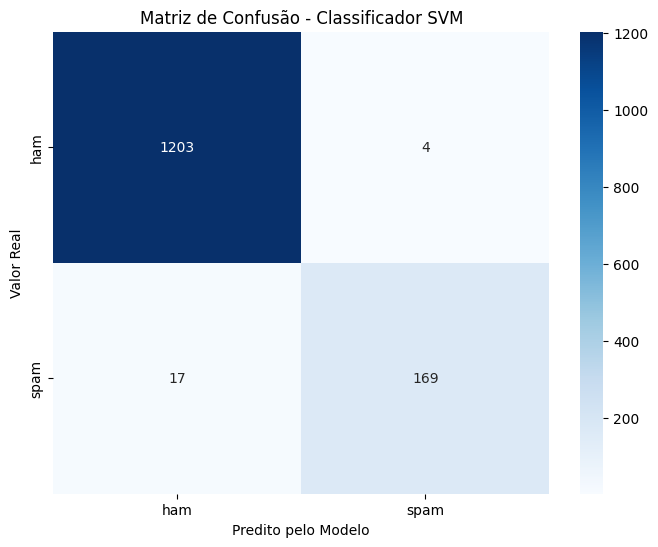

In [7]:
print("\n--- Etapa 4: Solução do Desafio (Modelo SVM) ---")

# Instancia o classificador SVM com os parâmetros exatos solicitados no desafio
model_svm = SVC(
    C=1.0,
    kernel='linear',
    degree=3,
    gamma='auto',
    random_state=42 # Adicionado para reprodutibilidade
)

# Treina o modelo SVM
print("Treinando o modelo SVM...")
model_svm.fit(train_features, train_labels)
print("Modelo SVM treinado com sucesso.")

# Faz predições no conjunto de teste
predicted_svm = model_svm.predict(test_features)

# Gera a matriz de confusão
confus_matrix_svm = confusion_matrix(test_labels, predicted_svm)

# Gera e exibe o gráfico da Matriz de Confusão
print("\nGerando o gráfico da Matriz de Confusão para o SVM...")
plt.figure(figsize=(8, 6))
sns.heatmap(
    confus_matrix_svm,
    annot=True,        # Mostra os números nas células
    fmt='d',           # Formata como inteiro
    cmap='Blues',      # Esquema de cores
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.xlabel('Predito pelo Modelo')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusão - Classificador SVM')
plt.show()